In [1]:
!test -f tz_1000.grib || wget https://get.ecmwf.int/repository/test-data/fieldlist/examples/tz_1000.grib

### Use case: interpolate, compute and plot mean from GRIB file input

Demonstrates the following workflow with the available earthkit components:

- read GRIB data with multiple parameters from a file
- filter temperature on a pressure level
- interpolate it onto another (lat-lon) grid and area
- compute the mean as an ndarray
- generate a plot for the mean

All of it is done by using an iteration and keeping only one GRIB field in memory at a time. No data is written to disk.

In [2]:
import io
import matplotlib.pyplot as plt
import numpy as np
from earthkit import data, regrid

fs = data.from_source("file", "tz_1000.grib")

In [3]:
# define the interpolation job
job = regrid.Job(grid='0.2/0.2', area='70/-30/20/70')

In [4]:
res = None
num = 0

# note: sel() first iterates through the messages and returns a
# view to the ones matching the conditions
for f in fs.sel(param="t", level=1000):
    # interpolate - 
    # the input is a GRIB message in memory
    # the output is a GRIB message in memory stored in a BytesIO object
    d = f.message()
    data_in = regrid.GribMemoryInput(d)
    data_out = io.BytesIO()
    job.execute(data_in, data_out)
   
    # load the resulting GRIB message
    g = data.from_source("memory", data_out.getvalue())[0]
    
    if res is None:
        # start accumulation
        res = g.to_numpy()
        
        # get metadata for plotting
        lat, lon = g.data("lat","lon")
    else:
        # accumulation
        res += g.to_numpy()
        
    num += 1

Compute the mean.

In [5]:
res /= num  
print(f"num={num}")
print(res)

num=4
[[265.83085632 265.98246765 266.07963562 ... 266.43144226 266.1516571
  265.85527039]
 [266.63774109 266.78666687 266.90385437 ... 266.40751648 266.03105164
  265.70170593]
 [266.97612    267.03471375 267.13798523 ... 265.98295593 265.56987
  265.27201843]
 ...
 [291.65483093 291.84501648 291.95585632 ... 296.33964539 296.48002625
  296.7363739 ]
 [291.69779968 291.89628601 291.98442078 ... 296.18461609 296.33525085
  296.45072937]
 [291.73320007 291.9304657  291.98881531 ... 296.06132507 296.15116882
  296.2429657 ]]


Result is scaled for plotting.

In [6]:
res -= 273.16

Generate plot.

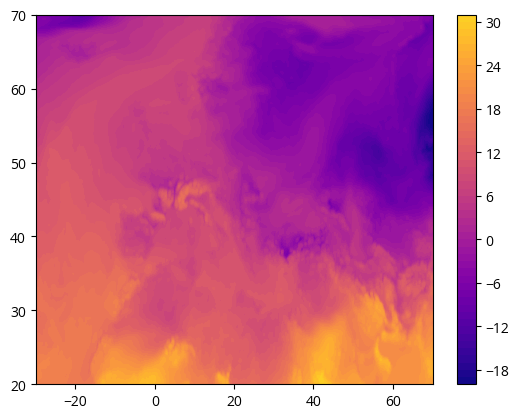

In [7]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(lon.flatten(), lat.flatten(), res.flatten(), vmin=-20, vmax=36, levels=56, cmap="plasma")
fig.colorbar(tcf)
plt.show()